# Reusable workflows

Nipype doesn't just allow you to create your own workflows. It also already comes with predefined workflows, developed by the community, for the community. For a full list of all workflows, look under the [Workflows](http://nipype.readthedocs.io/en/latest/documentation.html) section of the main homepage.

But to give you a short overview, there are workflows about:

**Functional MRI** workflows:
 - from **``fsl``** about ``resting state``, ``fixed_effects``, ``modelfit``, ``featreg``, ``susan_smooth`` and many more
 - from **``spm``** about ``DARTEL`` and ``VBM``

**Structural MRI** workflows
 - from **``ants``** about ``ANTSBuildTemplate`` and ``antsRegistrationBuildTemplate``
 - from **``freesurfer``** about ``bem``, ``recon`` and tessellation
 
**Diffusion** workflows:
 - from **``camino``** about ``connectivity_mapping``,  ``diffusion`` and  ``group_connectivity``
 - from **``dipy``** about ``denoise``
 - from **``fsl``** about ``artifacts``, ``dti``, ``epi``, ``tbss`` and many more
 - from **``mrtrix``** about ``connectivity_mapping``, ``diffusion`` and ``group_connectivity``

# How to load a workflow from Nipype

Let's consider the example of a functional MRI workflow, that uses FSL's Susan algorithm to smooth some data. To load such a workflow, we only need the following command:

In [1]:
from nipype.workflows.fmri.fsl.preprocess import create_susan_smooth
smoothwf = create_susan_smooth()

Once a workflow is created, we need to make sure that the mandatory inputs are specified. To see which inputs we have to define, we can use the command:

``create_susan_smooth?``

Which gives us the output:

```
Create a SUSAN smoothing workflow

Parameters
----------
Inputs:
    inputnode.in_files : functional runs (filename or list of filenames)
    inputnode.fwhm : fwhm for smoothing with SUSAN
    inputnode.mask_file : mask used for estimating SUSAN thresholds (but not for smoothing)

Outputs:
    outputnode.smoothed_files : functional runs (filename or list of filenames)
```

As we can see, we also need a mask file. For the sake of convenience, let's take the mean image of a functional image and threshold it at the 50% percentil:

In [2]:
!fslmaths /data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz \
    -Tmean -thrP 50 /output/sub-01_ses-test_task-fingerfootlips_mask.nii.gz

Now, we're ready to finish up our smooth workflow.

In [3]:
smoothwf.inputs.inputnode.in_files = '/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz'
smoothwf.inputs.inputnode.mask_file = '/output/sub-01_ses-test_task-fingerfootlips_mask.nii.gz'
smoothwf.inputs.inputnode.fwhm = 4
smoothwf.base_dir = '/output'

Before we run it, let's visualize the graph:

Populating the interactive namespace from numpy and matplotlib
170904-05:44:26,906 workflow INFO:
	 Generated workflow graph: /output/susan_smooth/graph.dot.png (graph2use=colored, simple_form=True).


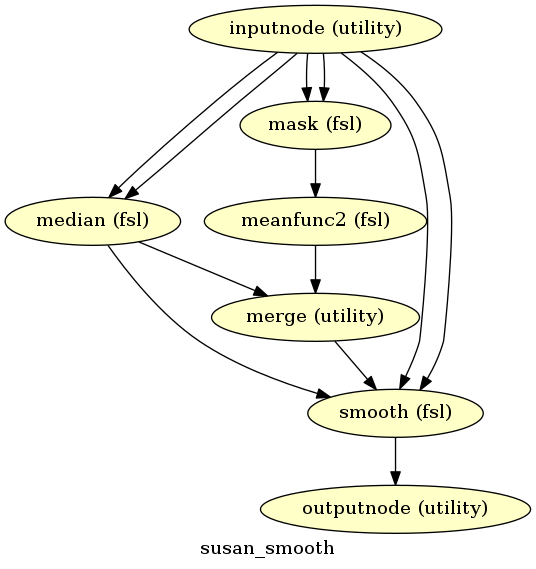

In [4]:
%pylab inline
from IPython.display import Image
smoothwf.write_graph(graph2use='colored', format='png', simple_form=True)
Image(filename='/output/susan_smooth/graph.dot.png')

And we're ready to go:

In [5]:
smoothwf.run('MultiProc', plugin_args={'n_procs': 4})

170904-05:44:26,954 workflow INFO:
	 Workflow susan_smooth settings: ['check', 'execution', 'logging']
170904-05:44:26,961 workflow INFO:
	 Running in parallel.
170904-05:44:26,965 workflow INFO:
	 Executing: mask ID: 0
170904-05:44:26,969 workflow INFO:
	 Executing: median ID: 2
170904-05:44:26,972 workflow INFO:
	 Executing node mask in dir: /output/susan_smooth/mask
170904-05:44:26,976 workflow INFO:
	 Executing node median in dir: /output/susan_smooth/median
170904-05:44:26,981 workflow INFO:
	 Executing node _mask0 in dir: /output/susan_smooth/mask/mapflow/_mask0
170904-05:44:26,984 workflow INFO:
	 Executing node _median0 in dir: /output/susan_smooth/median/mapflow/_median0
170904-05:44:26,989 workflow INFO:
	 Running: fslmaths /data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz -mas /output/sub-01_ses-test_task-fingerfootlips_mask.nii.gz /output/susan_smooth/mask/mapflow/_mask0/sub-01_ses-test_task-fingerfootlips_bold_mask.nii.gz
170904-05:44:26,9

Once it's finished, we can look at the results:

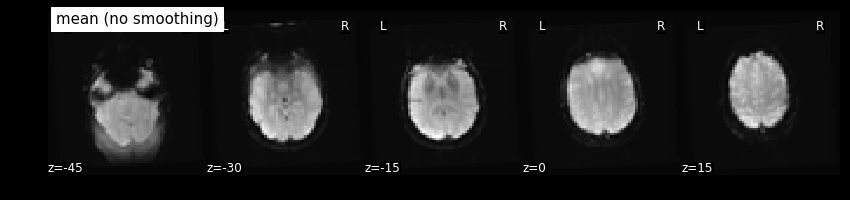

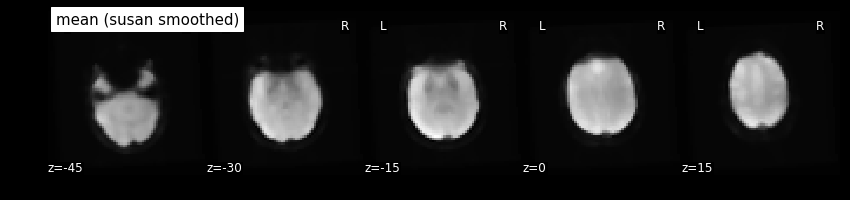

In [12]:
!fslmaths /data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz -Tmean fmean.nii.gz
!fslmaths /output/susan_smooth/smooth/mapflow/_smooth0/sub-01_ses-test_task-fingerfootlips_bold_smooth.nii.gz \
    -Tmean smean.nii.gz

from nilearn import image, plotting
plotting.plot_epi(
    'fmean.nii.gz', title="mean (no smoothing)", display_mode='z',
    cmap='gray', cut_coords=(-45, -30, -15, 0, 15))
plotting.plot_epi(
    'smean.nii.gz', title="mean (susan smoothed)", display_mode='z',
    cmap='gray', cut_coords=(-45, -30, -15, 0, 15))

# How to change node parameters from existing workflows

What if we want to change certain parameters of a loaded or already existing workflow? Let's first get the names of all the nodes in the workflow:

In [7]:
print(smoothwf.list_node_names())

['inputnode', 'mask', 'meanfunc2', 'median', 'merge', 'outputnode', 'smooth']


Ok. Hmm, what if we want to change the 'median' node, from 50% to 99%? For this, we first need to get the node.

In [8]:
median = smoothwf.get_node('median')

Now that we have the node, we can change it's value as we want:

In [9]:
median.inputs.op_string = '-k %s -p 99'

And we can run the workflow again...

In [10]:
smoothwf.run('MultiProc', plugin_args={'n_procs': 4})

170904-05:45:11,311 workflow INFO:
	 Workflow susan_smooth settings: ['check', 'execution', 'logging']
170904-05:45:11,318 workflow INFO:
	 Running in parallel.
170904-05:45:11,321 workflow INFO:
	 Executing: mask ID: 0
170904-05:45:11,324 workflow INFO:
	 [Job finished] jobname: mask jobid: 0
170904-05:45:11,326 workflow INFO:
	 Executing: median ID: 2
170904-05:45:11,331 workflow INFO:
	 Executing node median in dir: /output/susan_smooth/median
170904-05:45:11,339 workflow INFO:
	 Executing node _median0 in dir: /output/susan_smooth/median/mapflow/_median0
170904-05:45:11,345 workflow INFO:
	 Running: fslstats /data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz -k /output/sub-01_ses-test_task-fingerfootlips_mask.nii.gz -p 99 
170904-05:45:12,387 interface INFO:
	 stdout 2017-09-04T05:45:12.387402:1904.000000 
170904-05:45:12,904 workflow INFO:
	 [Job finished] jobname: median jobid: 2
170904-05:45:12,907 workflow INFO:
	 Executing: meanfunc2 ID: 1
1709

And now the output is:

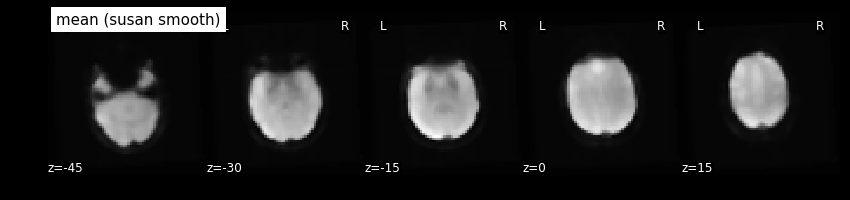

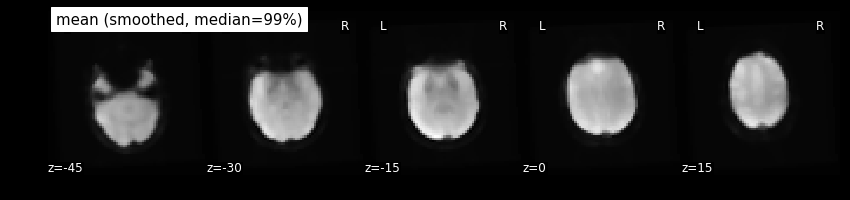

In [11]:
!fslmaths /output/susan_smooth/smooth/mapflow/_smooth0/sub-01_ses-test_task-fingerfootlips_bold_smooth.nii.gz \
    -Tmean mmean.nii.gz

from nilearn import image, plotting
plotting.plot_epi(
    'smean.nii.gz', title="mean (susan smooth)", display_mode='z',
    cmap='gray', cut_coords=(-45, -30, -15, 0, 15))
plotting.plot_epi(
    'mmean.nii.gz', title="mean (smoothed, median=99%)", display_mode='z',
    cmap='gray', cut_coords=(-45, -30, -15, 0, 15))